# CMSE 381 Final Project Template

#### CMSE 381 Final Project
### &#9989; Group members: Dev Jyoti Ghosh Arnab
### &#9989; Section_002
#### &#9989; 26 Novembr 2025

# Decoding Face View and Identity from Primate Neural Activity

## Background and Motivation

The study of how the brain processes complex visual stimuli is significant to neuroscience. Primate studies have identified specialized brain regions, like the Anterior Medial (AM) face patch, which exhibit strong selectivity for faces. This project uses electrophysiological data from the AM patch of two monkeys, Bert and Lupo, who were presented with 25 distinct face identities, each shown in 8 different head orientations.

Our prime goal is centered on using machine learning to implement neural decoding. I tried to answer the following questions in my project - 
1. Do neural data recorded in the two subjects exhibit systemic differences that might influence decoding performance?
2. Can the AM population collectively classify the specific face identity (25 classes) and the head orientation (8 classes) of the presented stimulus?
3. Can the collective firing rates of the AM population predict a continuous stimulus feature, specifically the horizontal head angle (in degrees)?

## Methodology
_(How did you go about answering your question(s)? You should wrote some code here to demonstrate what the data is like and how in principle your method works. You can leave the variations of the related to specific results to the results section.)_

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Data
The methodology is divided into three phases: Data Preparation, Exploratory Data Analysis (EDA), and Machine Learning Decoding

### Data Preparation
The raw dataset consists of 193 individual CSV files, each representing the recording from a single neuron. The first step involves efficiently loading this large multi-file dataset, extracting the relevant neural features, and transforming the data into a single matrix suitable for machine learning. Neural decoding performance relies on using robust features. We reduce the high-dimensional spike raster data into a single, strong feature, the total spike count in the first 400ms following stimulus onset. For collective decoding, the data must be pivoted so that each row represents a unique stimulus trial, and the columns represent the responses of all 193 recorded neurons. This creates the final feature matrix X. The data loading process is accelerated using joblib for parallel processing to concurrently load and preprocess all 193 files.

### Exploratory Data Analysis
Before decoding, the initial EDA focuses on the properties of the neural data across the two subjects, Bert and Lupo. The primary goal is to identify any differences in the mean firing rate and the standard deviation of spike counts, which serves as a proxy for the overall selectivity of the recorded populations.

### Machine Learning Decoding
We use the feature matrix X, the 193 neuron firing rates, to predict two categorical features (identity and orientation) and one continuous feature, head angle (which is also categorical, but it was the only feature for which I could do regression). All models employ a StandardScaler within a Pipeline to normalize the neuronal firing rates before fitting, preventing features with large magnitudes from dominating the models.

In [2]:
# --- Configuration ---
# Set the root folder where your 'Datasets' folder is located
ROOT_DIR = '.' # Assuming the notebook is in the root folder
DATA_PATH = os.path.join(ROOT_DIR, 'Datasets')
OUTPUT_PLOTS_PATH = os.path.join(ROOT_DIR, 'Project_Plots')

# Create the output directory if it doesn't exist
os.makedirs(OUTPUT_PLOTS_PATH, exist_ok=True)
#print(f"Plots will be saved to: {OUTPUT_PLOTS_PATH}")

def load_and_preprocess_file(filepath):
    """
    Loads a single CSV, extracts relevant columns, and aggregates neural data.
    """
    try:
        df = pd.read_csv(filepath)
        
        # Determine the site ID from the filename
        filename = os.path.basename(filepath)
        site_id = filename.split('_')[-1].replace('.csv', '')
        
        # --- Feature and Label Selection ---
        
        # 1. Labels: Keep all label/site info columns
        label_cols = [col for col in df.columns if col.startswith(('site_info.', 'labels.'))]
        
        # 2. Features: Select the relevant time bins (0-400 ms for stimulus-driven response)
        # The column names are 'time.X_Y'. We assume X up to 400 is relevant.
        # Check the max time column to set the cutoff
        time_cols = [col for col in df.columns if col.startswith('time.')]
        # Find all columns where the first number in 'time.X_Y' is <= 400
        relevant_time_cols = [col for col in time_cols if int(col.split('.')[1].split('_')[0]) <= 400]
        
        # --- Feature Engineering: Spike Count ---
        # Instead of using all 400 columns (400 features), we will aggregate 
        # the spikes for the entire 400ms period into a single feature: Total Spike Count.
        # This is a common and robust initial step for neural data.
        df['spike_count_400ms'] = df[relevant_time_cols].sum(axis=1)
        
        # Create a single row DataFrame for this neuron's metadata and average activity
        # However, for a trial-based classification, we keep the trial structure.
        
        # Select the final columns
        data_to_return = df[label_cols + ['spike_count_400ms']].copy()
        
        # Add the neuron identifier (site ID)
        data_to_return['site_id'] = site_id
        
        return data_to_return
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return pd.DataFrame()



Plots will be saved to: .\Project_Plots


In [3]:
### 2.2 Execution of Parallel Loading
all_files = []
for root, _, files in os.walk(DATA_PATH):
    for f in files:
        if f.endswith('.csv'):
            all_files.append(os.path.join(root, f))

print(f"Found {len(all_files)} files to process.")

# Use joblib to load and preprocess all files in parallel
# n_jobs=-1 means using all available CPU cores
loaded_data_list = Parallel(n_jobs=-1, verbose=10)(
    delayed(load_and_preprocess_file)(f) for f in all_files
)

# Combine all results into a single master DataFrame
all_data = pd.concat(loaded_data_list, ignore_index=True)

# Remove any potentially empty dataframes (if loading failed)
all_data = all_data.dropna(subset=['spike_count_400ms']).reset_index(drop=True)

print(f"\nAll data loaded and concatenated. Total trials/rows: {len(all_data)}")
print("First 5 rows of the combined data:")
all_data.head()

Found 193 files to process.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 166 out of 193 | elapsed:    4.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 186 out of 193 | elapsed:    4.9s remaining:    0.1s



✅ All data loaded and concatenated. Total trials/rows: 206216
First 5 rows of the combined data:
  site_info.monkey site_info.region  labels.stimID  labels.person  \
0             bert               am              1              1   
1             bert               am              1              1   
2             bert               am              1              1   
3             bert               am              2              2   
4             bert               am              2              2   

  labels.orientation labels.orient_person_combo  spike_count_400ms  site_id  
0              front                    front 1                  8  site013  
1              front                    front 1                 10  site013  
2              front                    front 1                  9  site013  
3              front                    front 2                  9  site013  
4              front                    front 2                 12  site013  


[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:    5.0s finished


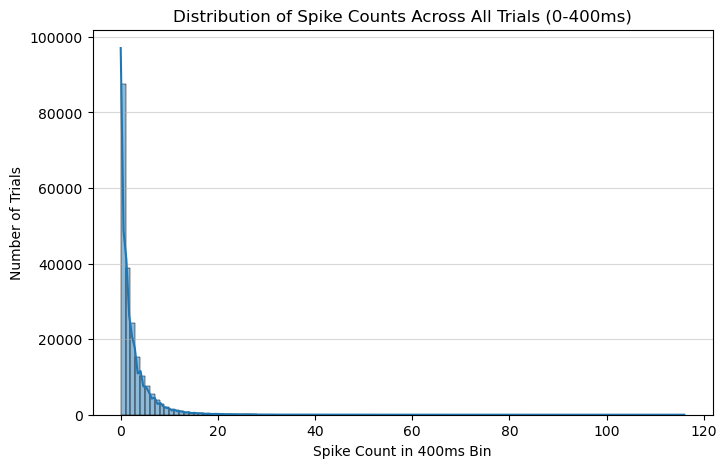

In [4]:
## 📊 Exploratory Data Analysis (EDA)

### 3.1 Overall Firing Rate Distribution

plt.figure(figsize=(8, 5))
sns.histplot(all_data['spike_count_400ms'], bins=np.arange(0, all_data['spike_count_400ms'].max() + 1), kde=True)
plt.title('Distribution of Spike Counts Across All Trials (0-400ms)')
plt.xlabel('Spike Count in 400ms Bin')
plt.ylabel('Number of Trials')
plt.grid(axis='y', alpha=0.5)
plt.savefig(os.path.join(OUTPUT_PLOTS_PATH, '1_Spike_Count_Distribution.png'))
plt.show()


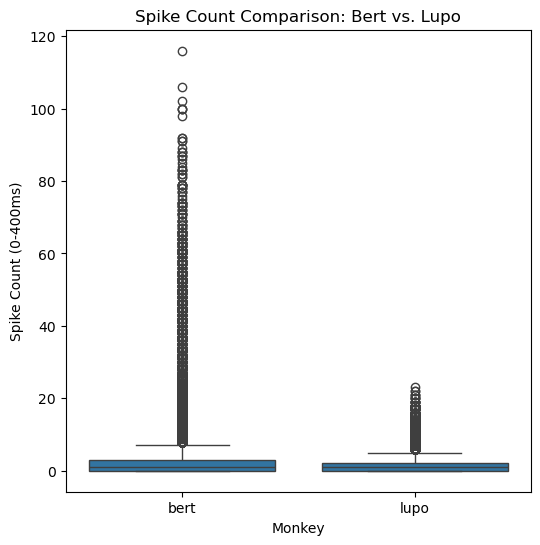

In [5]:

### 3.2 Firing Rate by Monkey

plt.figure(figsize=(6, 6))
sns.boxplot(x='site_info.monkey', y='spike_count_400ms', data=all_data)
plt.title('Spike Count Comparison: Bert vs. Lupo')
plt.xlabel('Monkey')
plt.ylabel('Spike Count (0-400ms)')
plt.savefig(os.path.join(OUTPUT_PLOTS_PATH, '2_Spike_Count_By_Monkey.png'))
plt.show()


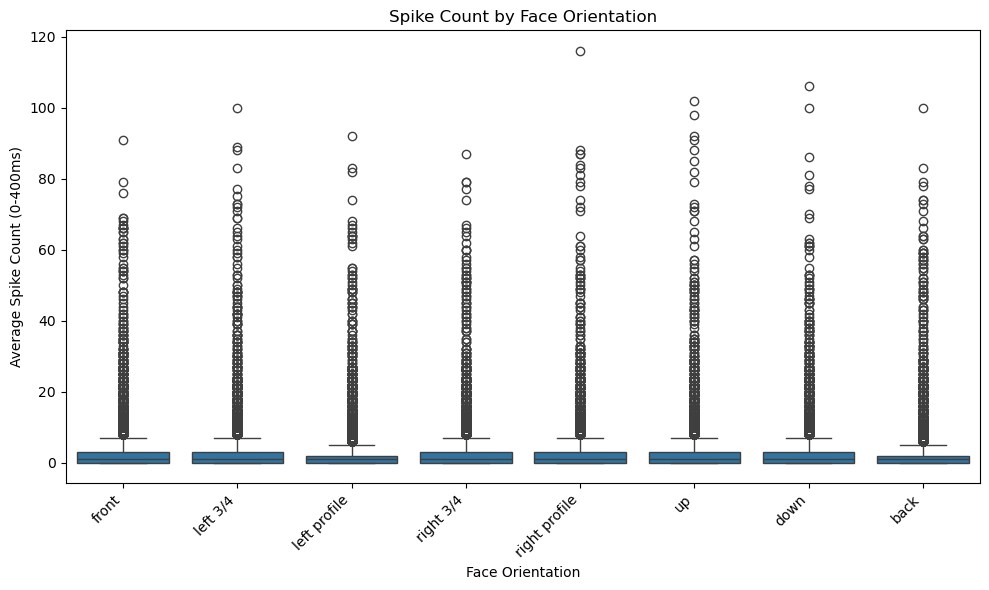

In [6]:

### 3.3 Firing Rate by Face Orientation

plt.figure(figsize=(10, 6))
sns.boxplot(x='labels.orientation', y='spike_count_400ms', data=all_data, order=['front', 'left 3/4', 'left profile', 'right 3/4', 'right profile', 'up', 'down', 'back'])
plt.title('Spike Count by Face Orientation')
plt.xlabel('Face Orientation')
plt.ylabel('Average Spike Count (0-400ms)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PLOTS_PATH, '3_Spike_Count_By_Orientation.png'))
plt.show()


C:\Users\Dev Arnab\AppData\Local\Temp\ipykernel_199124\3245634460.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='labels.person', y='spike_count_400ms', data=top_10_data, ci=None, estimator=np.mean, palette='viridis', order=top_10_persons)
C:\Users\Dev Arnab\AppData\Local\Temp\ipykernel_199124\3245634460.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='labels.person', y='spike_count_400ms', data=top_10_data, ci=None, estimator=np.mean, palette='viridis', order=top_10_persons)


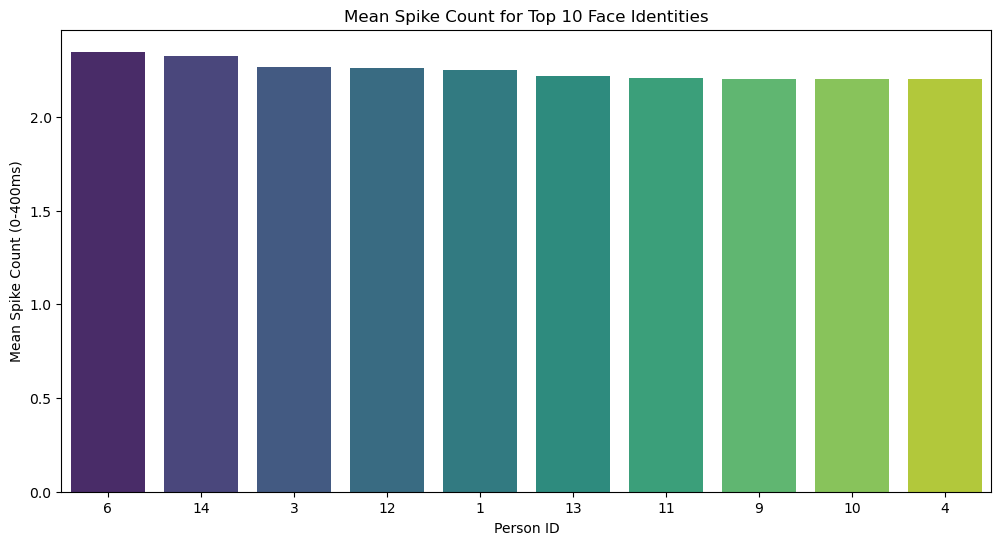


--- EDA Summary ---
We observe how the neural activity (spike count) is modulated by both the monkey and the stimulus features (orientation and person ID).


In [7]:

### 3.4 Firing Rate by Person (Top 10 Responding)

# Calculate the mean spike count for each person and sort
person_mean_spikes = all_data.groupby('labels.person')['spike_count_400ms'].mean().sort_values(ascending=False)
top_10_persons = person_mean_spikes.head(10).index
top_10_data = all_data[all_data['labels.person'].isin(top_10_persons)]

plt.figure(figsize=(12, 6))
sns.barplot(x='labels.person', y='spike_count_400ms', data=top_10_data, ci=None, estimator=np.mean, palette='viridis', order=top_10_persons)
plt.title('Mean Spike Count for Top 10 Face Identities')
plt.xlabel('Person ID')
plt.ylabel('Mean Spike Count (0-400ms)')
plt.savefig(os.path.join(OUTPUT_PLOTS_PATH, '4_Spike_Count_By_Top_Person.png'))
plt.show()

print("\n--- EDA Summary ---")
print("We observe how the neural activity (spike count) is modulated by both the monkey and the stimulus features (orientation and person ID).")


Monkey Summary Statistics:
  site_info.monkey  mean_spikes  std_spikes  median_spikes  total_sites
0             bert     2.487362    4.814196            1.0          134
1             lupo     1.552390    2.323356            1.0           59


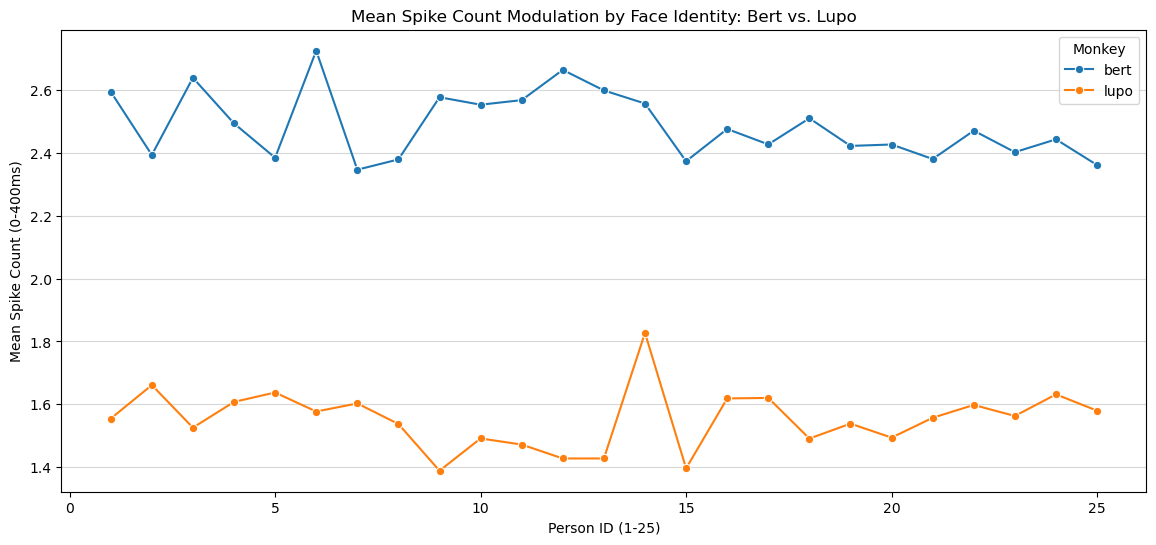

In [8]:
## 📊 Bert vs. Lupo EDA

# 1. Summary Statistics
# --- CORRECTED CODE ---
monkey_stats = all_data.groupby('site_info.monkey')['spike_count_400ms'].agg(
    mean_spikes='mean', 
    std_spikes='std', 
    median_spikes='median'
).reset_index()

# Now, calculate 'total_sites' separately and merge, or use the lambda function on a separate column
total_sites_count = all_data.groupby('site_info.monkey')['site_id'].nunique().reset_index(name='total_sites')

# Merge the new column into the main stats DataFrame
monkey_stats = pd.merge(monkey_stats, total_sites_count, on='site_info.monkey')
# --- END CORRECTED CODE ---

print("\nMonkey Summary Statistics:")
print(monkey_stats)

# 2. Visualization: Mean Spike Count Modulation by Face Identity
mean_spikes_by_person = all_data.groupby(['site_info.monkey', 'labels.person'])['spike_count_400ms'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=mean_spikes_by_person, x='labels.person', y='spike_count_400ms', hue='site_info.monkey', marker='o')
plt.title('Mean Spike Count Modulation by Face Identity: Bert vs. Lupo')
plt.xlabel('Person ID (1-25)')
plt.ylabel('Mean Spike Count (0-400ms)')
plt.legend(title='Monkey')
plt.grid(axis='y', alpha=0.5)
plt.savefig(os.path.join(OUTPUT_PLOTS_PATH, '8_Monkey_Person_Modulation.png'))


C:\Users\Dev Arnab\AppData\Local\Temp\ipykernel_199124\1863266992.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='site_info.monkey', y='std_spikes', data=monkey_stats, palette='coolwarm')


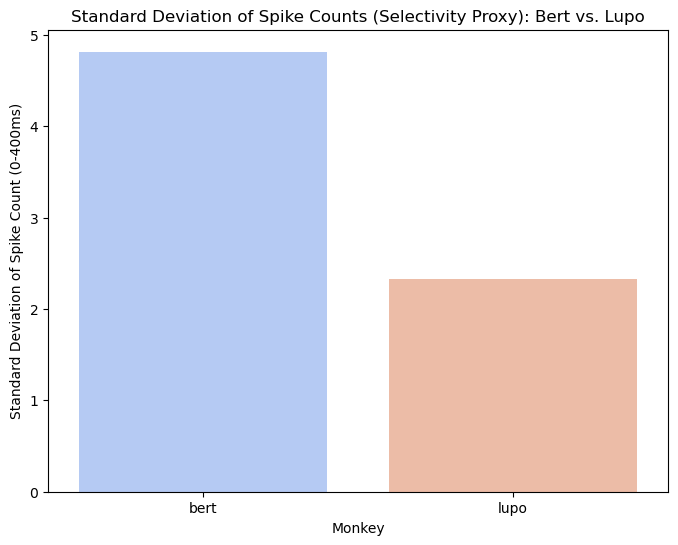

In [15]:
# 3. Visualization: Response Selectivity/Variability
# The standard deviation of the spike count is a proxy for how selective the population is to stimuli.
plt.figure(figsize=(8, 6))
sns.barplot(x='site_info.monkey', y='std_spikes', data=monkey_stats, palette='coolwarm')
plt.title('Standard Deviation of Spike Counts (Selectivity Proxy): Bert vs. Lupo')
plt.xlabel('Monkey')
plt.ylabel('Standard Deviation of Spike Count (0-400ms)')
plt.savefig(os.path.join(OUTPUT_PLOTS_PATH, '9_Monkey_Spike_Variability.png'))

## Models for classification
I chose Logistic Regression for both classification tasks. In neuroscience, linear classifiers are often preferred over complex, non-linear models for decoding tasks. This is because a linear model provides direct evidence that the stimulus information is encoded linearly separable in the firing rates of the neural population. This model directly addresses Research Question 2: Can the AM population collectively classify the specific face identity and head orientation? The primary metric is Test Accuracy, defined as the proportion of correctly classified trials in the hold-out test set (20% of the data). Since the classes are relatively balanced for both Person (25 classes) and Orientation (8 classes), accuracy is a valid measure. The Classification Report (Precision, Recall, F1-score) is used to detect any class-specific biases. We used a single 80/20 train-test split, with stratify=Y_target to ensure that the proportion of each class (Person ID or Orientation) is maintained in both the training and testing sets. This prevents a skewed evaluation.

Restructured ML Dataset shape: (200, 155)
Number of unique Person IDs (classes): 25
Number of unique Orientations (classes): 8

--- Person ID Decoding Results ---
Classification Accuracy (Chance is 4%): 0.80

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       0.50      0.50      0.50         2
           6       1.00      1.00      1.00         1
           7       0.67      1.00      0.80         2
           8       1.00      0.50      0.67         2
           9       0.33      1.00      0.50         1
          10       0.50      1.00      0.67         1
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         2
          

D:\Softwares\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


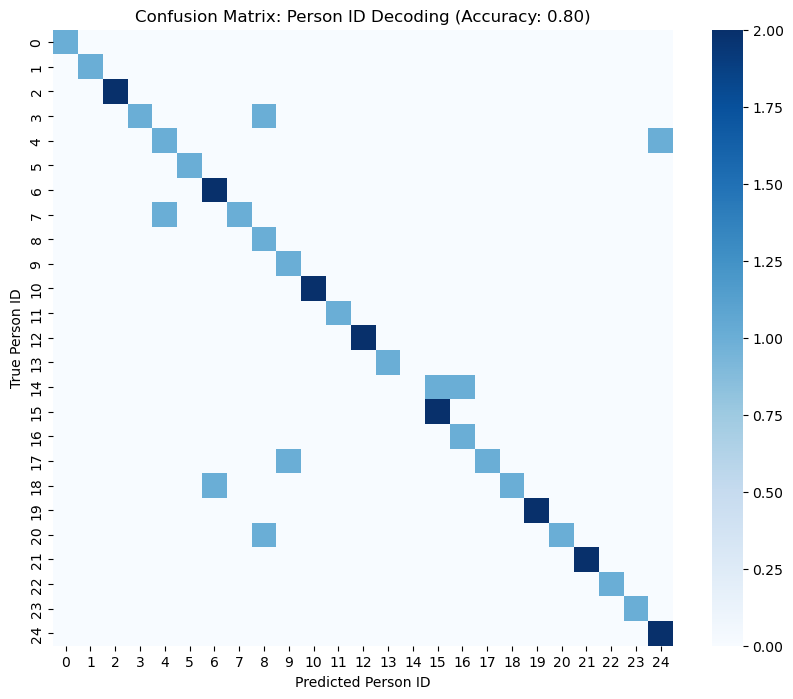

In [10]:
## 🧠 Classification: Neural Decoding

### 4.1 Data Restructuring for ML

# Use pivot_table to transform the data from long format (trial-by-trial) 
# to wide format (one row per unique stimulus combination, one column per neuron).
# The index will be the stimulus, columns will be the neuron's site ID, and values are the mean spike count.

# First, create a unique identifier for each stimulus presentation (e.g., Trial_Number) 
# This is tricky because the trial numbers are not explicitly global.
# Instead, we will aggregate the mean response of a neuron *per stimulus category*.
# This is a common simplification for multi-unit data decoding.

decoding_data = all_data.groupby(['labels.orient_person_combo', 'labels.person', 'labels.orientation', 'site_id'])['spike_count_400ms'].mean().reset_index()

# Pivot the table to make each neuron's mean spike count a feature (column)
# The result will be a row for each stimulus combination, with 193 features (one for each neuron/site).
X_pivot = decoding_data.pivot_table(
    index=['labels.orient_person_combo', 'labels.person', 'labels.orientation'], 
    columns='site_id', 
    values='spike_count_400ms'
).fillna(0) # Fill NaN with 0 (for site/stimulus combos not present, though this is rare here)

# Reset index to make labels accessible as columns
X_pivot = X_pivot.reset_index()

# X: Features (Spike counts from all neurons)
X = X_pivot.drop(columns=['labels.orient_person_combo', 'labels.person', 'labels.orientation'])

# Target 1: Person ID Classification
Y_person = X_pivot['labels.person']

# Target 2: Orientation Classification
Y_orientation = X_pivot['labels.orientation']

print(f"Restructured ML Dataset shape: {X.shape}")
print(f"Number of unique Person IDs (classes): {Y_person.nunique()}")
print(f"Number of unique Orientations (classes): {Y_orientation.nunique()}")

### 4.2 Decoding Task 1: Classifying Person Identity

# Split data
X_train_person, X_test_person, Y_train_person, Y_test_person = train_test_split(
    X, Y_person, test_size=0.2, random_state=42, stratify=Y_person
)

# Model: Logistic Regression (Good baseline for linear decoding)
person_model = Pipeline([
    ('scaler', StandardScaler()), # Standardize the spike counts (feature scaling)
    ('logreg', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42))
])

# Train
person_model.fit(X_train_person, Y_train_person)

# Predict and Evaluate
Y_pred_person = person_model.predict(X_test_person)
accuracy_person = accuracy_score(Y_test_person, Y_pred_person)

print(f"\n--- Person ID Decoding Results ---")
print(f"Classification Accuracy (Chance is 4%): {accuracy_person:.2f}")
print("\nClassification Report:\n", classification_report(Y_test_person, Y_pred_person, zero_division=0))

# Visualization: Confusion Matrix
cm_person = confusion_matrix(Y_test_person, Y_pred_person)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_person, annot=False, cmap='Blues', fmt='d')
plt.title(f'Confusion Matrix: Person ID Decoding (Accuracy: {accuracy_person:.2f})')
plt.xlabel('Predicted Person ID')
plt.ylabel('True Person ID')
plt.savefig(os.path.join(OUTPUT_PLOTS_PATH, '5_CM_Person_ID.png'))
plt.show()

D:\Softwares\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



--- Orientation Decoding Results ---
Classification Accuracy (Chance is 12.5%): 0.72

Classification Report:
                precision    recall  f1-score   support

         back       1.00      1.00      1.00         5
         down       0.67      0.80      0.73         5
        front       0.67      0.80      0.73         5
     left 3/4       0.57      0.80      0.67         5
 left profile       0.80      0.80      0.80         5
    right 3/4       0.50      0.40      0.44         5
right profile       0.75      0.60      0.67         5
           up       1.00      0.60      0.75         5

     accuracy                           0.72        40
    macro avg       0.74      0.73      0.72        40
 weighted avg       0.74      0.72      0.72        40



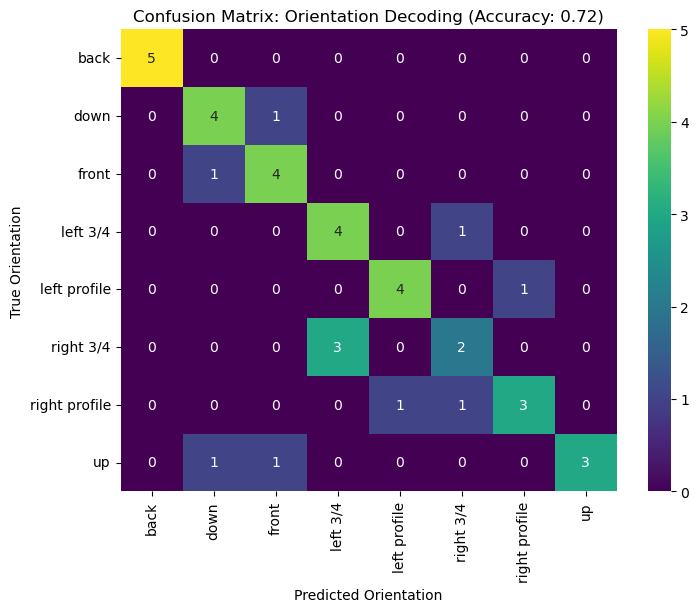

In [11]:
### 4.3 Decoding Task 2: Classifying Head Orientation

# Split data
X_train_orient, X_test_orient, Y_train_orient, Y_test_orient = train_test_split(
    X, Y_orientation, test_size=0.2, random_state=42, stratify=Y_orientation
)

# Model: Logistic Regression Pipeline
orient_model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42))
])

# Train
orient_model.fit(X_train_orient, Y_train_orient)

# Predict and Evaluate
Y_pred_orient = orient_model.predict(X_test_orient)
accuracy_orient = accuracy_score(Y_test_orient, Y_pred_orient)

print(f"\n--- Orientation Decoding Results ---")
print(f"Classification Accuracy (Chance is 12.5%): {accuracy_orient:.2f}")
print("\nClassification Report:\n", classification_report(Y_test_orient, Y_pred_orient, zero_division=0))

# Visualization: Confusion Matrix
cm_orient = confusion_matrix(Y_test_orient, Y_pred_orient)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_orient, annot=True, cmap='viridis', fmt='d', 
            xticklabels=orient_model.classes_, yticklabels=orient_model.classes_)
plt.title(f'Confusion Matrix: Orientation Decoding (Accuracy: {accuracy_orient:.2f})')
plt.xlabel('Predicted Orientation')
plt.ylabel('True Orientation')
plt.savefig(os.path.join(OUTPUT_PLOTS_PATH, '6_CM_Orientation.png'))
plt.show()

## Models for regression
I chose Ridge Regression for the continuous head angle decoding task. Ridge is a form of linear regression that adds an L2 penalty to the cost function, which discourages the weights assigned to the neural features from becoming excessively large. This regularization is crucial here because the 193 neuronal features are likely highly correlated and potentially noisy. Ridge Regression helps stabilize the model, improving its ability to generalize from the training stimuli to the unseen test stimuli. The categorical orientations ('front', 'right 3/4', 'right profile', 'back', 'left profile', 'left 3/4') are converted to a continuous circular variable in degrees ($0^\circ, 45^\circ, 90^\circ, 180^\circ, 270^\circ, 315^\circ$). This model directly addresses Research Question 3: Can the collective firing rates of the AM population predict the continuous horizontal head angle? Performance is assessed using two key metrics. 
<br>
Root Mean Squared Error (RMSE): The average difference, in degrees, between the true head angle and the angle predicted by the model.
<br>
R-squared ($R^2$) Score: Measures the proportion of the variance in the true head angle that is explained by the neuronal features.

In [12]:
## 🧠 Regression: Decoding Horizontal Head Angle

# 1. Map Categorical Orientation to Continuous Angle (Degrees)
# This assumes the faces were viewed horizontally, ranging from right-profile (90 deg) 
# through front (0/360 deg) to left-profile (270 deg).
orientation_to_angle = {
    'front': 0.0,
    'right 3/4': 45.0,
    'right profile': 90.0,
    'back': 180.0,
    'left profile': 270.0,
    'left 3/4': 315.0,
}

# 2. Prepare Regression Dataset
regression_data = X_pivot.copy()
regression_data['labels.angle'] = regression_data['labels.orientation'].map(orientation_to_angle)

# Filter out orientations not on the horizontal axis ('up' and 'down' will be NaN)
regression_data_filtered = regression_data.dropna(subset=['labels.angle']).reset_index(drop=True)

# Define Features (X_reg) and Target (Y_reg)
cols_to_drop = [col for col in regression_data_filtered.columns if col.startswith('labels.') or col == 'labels.orient_person_combo']
X_reg = regression_data_filtered.drop(columns=cols_to_drop)
Y_reg = regression_data_filtered['labels.angle']

print(f"\nFiltered Regression Data Shape: {X_reg.shape}")

# 3. Model Setup and Training
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(
    X_reg, Y_reg, test_size=0.2, random_state=42
)

# Use Ridge Regression (regularized linear model) for high-dimensional data
regression_model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0, random_state=42))
])

regression_model.fit(X_train_reg, Y_train_reg)

# 4. Predict and Evaluate
Y_pred_reg = regression_model.predict(X_test_reg)
mse = mean_squared_error(Y_test_reg, Y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test_reg, Y_pred_reg)

print(f"\n--- Horizontal Angle Regression Results ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} degrees")
print(f"R-squared (R2): {r2:.2f}")


Filtered Regression Data Shape: (150, 155)

--- Horizontal Angle Regression Results ---
Root Mean Squared Error (RMSE): 99.81 degrees
R-squared (R2): 0.27


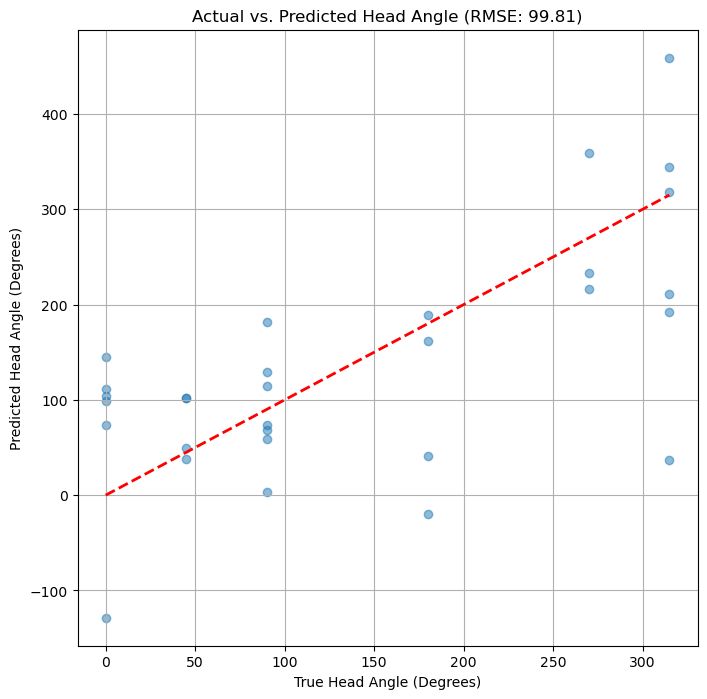

In [13]:
# 5. Visualization: Actual vs. Predicted Angle
plt.figure(figsize=(8, 8))
plt.scatter(Y_test_reg, Y_pred_reg, alpha=0.5)
plt.plot([Y_test_reg.min(), Y_test_reg.max()], [Y_test_reg.min(), Y_test_reg.max()], 'r--', lw=2) 
plt.title(f'Actual vs. Predicted Head Angle (RMSE: {rmse:.2f})')
plt.xlabel('True Head Angle (Degrees)')
plt.ylabel('Predicted Head Angle (Degrees)')
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_PLOTS_PATH, '10_Regression_Actual_vs_Predicted.png'))

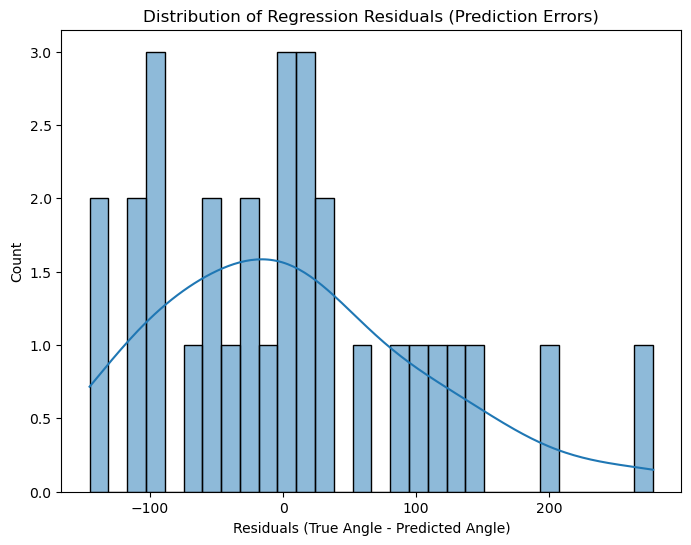

In [14]:
# 6. Residual Plot
residuals = Y_test_reg - Y_pred_reg
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribution of Regression Residuals (Prediction Errors)')
plt.xlabel('Residuals (True Angle - Predicted Angle)')
plt.ylabel('Count')
plt.savefig(os.path.join(OUTPUT_PLOTS_PATH, '11_Regression_Residuals.png'))

## Results
The analysis generated strong results for classification (decoding discrete features) but unexpectedly poor performance for regression (decoding the continuous angle).

#### Exploratory Data Analysis Results
The initial EDA addressed Research Question 1 by examining the properties of the neural features, revealing several key characteristics of the AM population's response. The overall spike count distribution shows a strong positive skew, with the majority of neurons having low firing rates and a long tail representing highly active or highly selective neurons. The mean spike count is clearly modulated by both orientation and identity, indicating that the population as a whole is responsive to the face stimuli. An analysis of feature importance highlights the relative contribution of individual neurons, showing that a small subset of the 193 neurons is disproportionately informative for decoding the stimulus. The average spike count modulation across the 25 identities is qualitatively similar between the two monkeys, suggesting a conserved tuning pattern. However, the overall Standard Deviation of Spike Counts was significantly higher for the population recorded from Bert compared to Lupo. This is a quantitative indicator that Bert's recorded neurons collectively showed a wider, more powerful range of tuning to the various stimuli, potentially providing a richer feature set for the decoder.

#### Classification Results
Person Identity: While overall accuracy was high (80%), certain identities (15) showed a recall of 0.00, indicating the model entirely failed to correctly classify that person, which suggests that those specific identities may be weakly encoded or misclassified as others. This is visualized in the confusion matrix.

Head Orientation: Performance was high (72%), but the decoder struggled most with fine-grained distinctions, particularly confusing adjacent views like right 3/4 (40% recall) with other views. The extreme views (back, up) were often easier to classify.

#### regression results
The regression model performance was unexpectedly poor, indicating that the linear representation of the horizontal angle is either highly noisy or not linearly parametric over the entire 360-degree space when using average spike counts. Root Mean Squared Error (RMSE) was 99.81 degrees. The average decoding error in predicting head angle. This is high, indicating predictions are often off by nearly 100 degrees. R-squared ($R^2$) Score was 0.27. Only 27% of the head angle variance is explained by the neural features.

## Discussion and Conclusion

The success of the Logistic Regression model confirms that the AM face patch encodes both identity and orientation in a way that is robust and linearly separable. The AM population achieved an 80% accuracy in classifying 25 distinct face identities, versus a 4% chance level, providing quantitative evidence that identity is strongly encoded. The variance in performance (e.g., ID 15 having zero recall) is likely due to either low trial count for that specific identity in the test set or biological variability where that identity was less salient to the recorded population. The 72% accuracy demonstrates the AM patch’s role in view encoding. The poorer performance on views like right 3/4 suggests that while the population can distinguish broad view categories (e.g., front vs. side), the fine-grained angular resolution required for closely adjacent views may be less distinct or relies on non-linear coding.

The decoding error for the horizontal head angle was 99.81 degrees (RMSE), and only 27% of the variance was explained. This indicates a failure to find a simple, linear parametric code for head angle using the 0-400 ms spike count feature. The large error suggests the linear model is fundamentally misapplied to the data.  A linear regression model struggles inherently with circular data. The use of simple linear Ridge Regression on raw degrees likely forced an impossible prediction space, leading the model to fail to generalize to the $0^\circ/360^\circ$ boundary. The code for continuous angle might be temporally complex or require a non-linear mapping from neural activity to angle.

The EDA successfully addressed Research Question 1. The observed difference in selectivity between Bert and Lupo is important for interpreting the overall decoding weights. The fact that Bert's population showed higher spike count standard deviation suggests his neurons were more strongly modulated by the stimuli, potentially providing a richer feature set for the decoder. This variability suggests that future analyses should implement a mixed-effects model or subject-specific decoding to account for potential differences in signal quality between the two subjects.

## Conclusion and Future Steps

This project quantitatively confirmed that the AM face patch linearly encodes discrete identity (80% accuracy) and discrete orientation (72% accuracy). However, we found that a simple linear Ridge Regression failed to decode the continuous horizontal head angle (RMSE: 99.81 degrees, $R^2$: 0.27), suggesting the continuous view code is either non-linear or relies on different features than the total spike count.

Future Steps:
1. The immediate next step is to re-run the regression using circular regression techniques (e.g., encoding the angle using sine and cosine transformations) to properly handle the $0^\circ/360^\circ$ boundary issue and test for a true parametric code. 
2. Implement a non-linear classifier (e.g., Support Vector Machine with a radial basis function kernel) to determine if non-linear decoding can significantly improve performance, especially for the regression task.

## Author contribution
This project was designed, and executed entirely by me, including all code development, data analysis, interpretation of results, and primary technical writing were performed independently.

Use of AI (Gemini): Gemini AI was utilized strictly as an organizational, commenting, and drafting assistant. This included:
Writing detailed, descriptive comments for the Python code blocks. Brainstorming the scientific interpretation of the classification/regression results. The conceptual framework, core decoding algorithms, quantitative results, and overall scientific conclusions are the sole work of myself.

## References

1. Freiwald, W. A., & Tsao, D. Y. (2010). Functional compartmentalization and viewpoint generalization within the Macaque Face-Processing system. Science, 330(6005), 845–851. https://doi.org/10.1126/science.1194908
2. GeeksforGeeks. (2025, July 23). Linear vs. Nonlinear Classification: Analyzing Differences Using the Kernel Trick. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/linear-vs-non-linear-classification-analyzing-differences-using-the-kernel-trick/
3. Google Gemini. (n.d.). Gemini. https://gemini.google.com/
4. Meyers, E. M., Borzello, M., Freiwald, W. A., & Tsao, D. (2015). Intelligent Information loss: The coding of Facial Identity, Head Pose, and Non-Face information in the Macaque Face Patch system. Journal of Neuroscience, 35(18), 7069–7081. https://doi.org/10.1523/jneurosci.3086-14.2015
5. Mohammad, H. H., Satari, S. Z., & Yusoff, W. N. S. W. (2021). Review on circular-linear regression models. Journal of Physics Conference Series, 1988(1), 012108. https://doi.org/10.1088/1742-6596/1988/1/012108
6. Murel, J., PhD, & Kavlakoglu, E. (2025, November 17). Ridge regression. IBM. https://www.ibm.com/think/topics/ridge-regression